

#                          Project : Medical Treatment

# Problem statement

A lot has been said during the past several years about how precision medicine and, more concretely, how genetic testing is going to disrupt the way diseases like cancer are treated.

But this is only partially happening due to the huge amount of manual work still required. Once sequenced, a cancer tumor can have thousands of genetic mutations. But the challenge is distinguishing the mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers). 

Currently this interpretation of genetic mutations is being done manually. This is a very time-consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature.

We need to develop a Machine Learning algorithm that, using this knowledge base as a baseline, automatically classifies genetic variations.

This problem was a competition posted on Kaggle with a award of $15,000. This was launched by  Memorial Sloan Kettering Cancer Center (MSKCC), accepted by NIPS 2017 Competition Track,  because we need your help to take personalized medicine to its full potential.

You can check all details about the competition from following link :
https://www.kaggle.com/c/msk-redefining-cancer-treatment

In order to get the dataset please create a login account to Kaggle and go to this problem statement page(given above) and download 2 dataset

***training_variants.zip*** and ***training_text.zip***

## Analysis of the problem statement

Lets first understand the data set provided and using that dataset we will try to understand the above problem in Machine Learning world. Since, the dataset is huge lets load it using python itself

In [1]:
# Loading all required packages
# If any of it fails, do not panic. Just install it using "pip3 install <package_name>" or by using conda install package_name
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

There are 2 data files provided for solving this problem. I have kept them inside a folder training. So lets load them

In [2]:
# Loading training_variants. Its a comma seperated file
data_variants=pd.read_csv('training/training_variants')
# Loading training_text dataset. This is seperated by ||
data_text=pd.read_csv("training/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

In [3]:
data_variants.head(3)

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2


<p>
    Let's understand above data. There are 4 fields above: <br>
    <ul>
        <li><b>ID : </b>row id used to link the mutation to the clinical evidence</li>
        <li><b>Gene : </b>the gene where this genetic mutation is located </li>
        <li><b>Variation : </b>the aminoacid change for this mutations </li>
        <li><b>Class :</b> class value 1-9, this genetic mutation has been classified on</li>
    </ul>
    
Keep doing more analysis  on above data.

In [4]:
data_variants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [5]:
data_variants.describe()

,ID,Class
count,3321.000000,3321.000000
mean,1660.000000,4.365854
std,958.834449,2.309781
min,0.000000,1.000000
25%,830.000000,2.000000
50%,1660.000000,4.000000
75%,2490.000000,7.000000
max,3320.000000,9.000000


In [6]:
# Checking dimention of data
data_variants.shape

(3321, 4)

In [7]:
# Clecking column in above data set
data_variants.columns

Index(['ID', 'Gene', 'Variation', 'Class'], dtype='object')


Now lets explore about data_text

In [8]:
data_text.head(3)

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...


So above dataset have 2 columns. ID and Text column. We can also observe column ID which is common in both the dataset. Lets keep exploring it.

In [9]:
data_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
ID      3321 non-null int64
TEXT    3316 non-null object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB


In [10]:
data_text.describe()

,ID
count,3321.000000
mean,1660.000000
std,958.834449
min,0.000000
25%,830.000000
50%,1660.000000
75%,2490.000000
max,3320.000000


In [11]:
data_text.shape

(3321, 2)

In [12]:
data_text.columns

Index(['ID', 'TEXT'], dtype='object')

So, in short my datasets looks like this
 * data_variants (ID, Gene, Variations, Class)
 * data_text(ID, text)

Ok, now we understood the dataset. Lets try to understand the same problem from Machine Learning point of view

We want to predict about class of cancer. Now question is what kind of data is present in class column. 

In [13]:
data_variants.Class.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

This is descrete data so it is ***classification*** problem and since there are multiple descrete output possible so we can call it ***Multi class*** classification problem

***Important note*** : This is medical related problem so correct results are very important. Error can be really costly here so we would like to have result  for each class in terms of Probablity. We might not be much bothered about time taken by ML algorithm as far as it is reasonable. 

We also want our model to be highly interpritable because a medical practitionar want to also give proper reasonining on why ML algorithm is predicting any class. 

We will evaluate our model using Confution matrix and Multi class log-loss

Ok, now we understood the problem statement. Let's work on the solution. 

We have huge amount of text data. So, we need to pre process it. So lets write a function for the same.

In [14]:
# We would like to remove all stop words like a, is, an, the, ... 
# so we collecting all of them from nltk library
#import nltk
#from nltk.corpus import stopwords
#nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

In [15]:

def data_text_preprocess(total_text,ind,col):
    # Remove int values from text data as that might not be imp
    if type(total_text)is not int:
        string=""
        # replacing all special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', str(total_text))
        # replacing multiple spaces with single space
        total_text=re.sub('\s+',' ',str(total_text))
        # bring whole text to same lower-case scale.
        total_text=total_text.lower()
        
        
        for word in total_text.split():    
        # if the word is a not a stop word then retain that word from text
            if not word in stop_words:
                string+=word+" "
        
        
        data_text[col][ind]=string
             
            
        

In [16]:
# Below code will take some time because its huge text (took 8 minute on my 8 GB RAM system), so run it and have a cup of coffee )

for index,row in data_text.iterrows():
    if type(row['TEXT'])is str:
        data_text_preprocess(row['TEXT'],index,'TEXT')
    

Let's merge both the dataset. Remember that ID was common column. So lets use it to merge.

In [17]:
#merging both gene_variations and text data based on ID
result=pd.merge(data_variants,data_text,on='ID',how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


It's very important to look for missing values. Else they create problem in final analysis

In [18]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


We can see many rows with missing data. Now the question is what to do with this missing value. One way could be that we can drop these rows having missing values or we can do some imputation in it. Let's go with imputation only. But question is what to impute here :

How about merging Gene and Variation column. Let's do it:

In [19]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

Let's cross check it once again if there is any missing values

In [20]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT


so all missing values are gone now.

## Creating Training, Test and Validation data

Before we split the data into taining, test and validation data set. We want to ensure that all spaces in Gene and Variation column to be replaced by _.

In [21]:
y_true=result['Class'].values
result.Gene=result.Gene.str.replace('\s+','_')
result.Variation=result.Variation.str.replace('\s+','_')


Ok, so we can now start our split process in train, test and validation data set.

In [22]:
# Splitting the data into train and test set 
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
#print(X_train)
# split the train data now into train validation and cross validation
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [23]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


Let's look at the distribution of data in train, test and validation set.

In [24]:
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

In [25]:
train_class_distribution

1    363
2    289
3     57
4    439
5    155
6    176
7    609
8     12
9     24
Name: Class, dtype: int64

So, what does above variable suggest us. This means in my train dataset we have class 1 values with count of 363, class 2 values having count of 289 and so on. It will be better idea to visualise it in graph format.

*** Visualizing for train class distrubution***

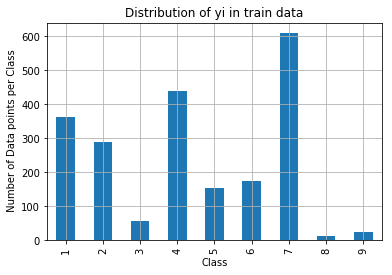

In [26]:
my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel(' Number of Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

Let's look at distribution in form of percentage

In [27]:
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)


Let's visualize the same for test set

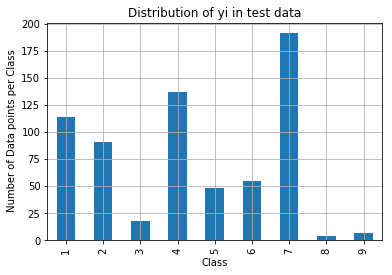

In [28]:
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel(' Number of Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

Let's look at distribution in form of percentage

In [29]:
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)


Let's visualize for cross validation set

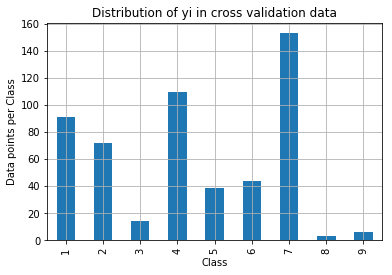

In [30]:
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

Let's look at distribution in form of percentage

In [31]:
sorted_yi = np.argsort(-cv_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


Now question is because we need log-loss as final evaluation metrics how do we say that model we are going to build will be good model. For doing this we will build a random model and will evaluate log loss. Our model should return lower log loss value than this.

## Building a Random model

In [32]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

In [33]:
# we create a output array that has exactly same size as the CV data
cv_predicted_y=np.zeros((cv_data_len,9))
for i in range (cv_data_len):
    random_probs=np.random.rand(1,9)
    cv_predicted_y[i]=((random_probs/sum(sum(random_probs)))[0])
print("Log loss on cross validation data using random model is",log_loss(y_cv,cv_predicted_y,eps=1e-15))

Log loss on cross validation data using random model is 2.5206718733747873


In [34]:
# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))


Log loss on Test Data using Random Model 2.458126773066955


In [35]:
# Lets get the index of max probablity
predicted_y =np.argmax(test_predicted_y, axis=1)

In [36]:
# Lets see the output. these will be 665 values present in test dataset
predicted_y

array([1, 0, 6, 8, 0, 3, 6, 4, 7, 0, 3, 2, 2, 4, 8, 5, 7, 7, 7, 5, 0, 1,
       1, 5, 4, 8, 1, 3, 0, 7, 6, 6, 8, 0, 2, 4, 4, 2, 0, 5, 7, 3, 4, 6,
       7, 1, 2, 1, 0, 4, 6, 6, 3, 0, 2, 1, 1, 3, 6, 2, 1, 8, 6, 0, 6, 8,
       0, 4, 1, 4, 8, 7, 4, 1, 0, 1, 5, 0, 7, 4, 5, 1, 2, 5, 5, 7, 8, 6,
       1, 5, 5, 2, 1, 2, 5, 3, 6, 3, 7, 7, 8, 0, 0, 7, 3, 6, 2, 6, 8, 8,
       2, 1, 7, 3, 6, 7, 0, 6, 1, 5, 7, 6, 4, 8, 0, 0, 1, 6, 1, 8, 6, 1,
       2, 0, 3, 0, 4, 7, 2, 5, 0, 6, 6, 1, 1, 4, 2, 8, 7, 5, 6, 6, 6, 7,
       3, 2, 4, 4, 2, 0, 1, 3, 2, 3, 2, 1, 7, 0, 4, 0, 6, 4, 8, 7, 6, 7,
       2, 8, 4, 5, 2, 6, 4, 4, 5, 0, 1, 3, 7, 6, 8, 2, 6, 8, 3, 2, 8, 1,
       2, 6, 5, 2, 4, 1, 5, 4, 4, 1, 8, 4, 1, 8, 5, 1, 1, 8, 1, 1, 6, 5,
       8, 3, 0, 2, 3, 3, 8, 2, 4, 6, 5, 7, 6, 2, 0, 0, 5, 8, 2, 3, 6, 1,
       0, 7, 4, 7, 1, 8, 1, 5, 4, 3, 1, 7, 5, 0, 3, 7, 3, 7, 7, 7, 8, 4,
       4, 6, 2, 5, 5, 1, 3, 5, 2, 6, 5, 7, 6, 8, 5, 0, 3, 4, 3, 0, 1, 2,
       4, 6, 2, 0, 2, 5, 3, 5, 7, 3, 1, 8, 6, 2, 5,

So you can see the index value ranging from 0 to 8. So, lets make it as 1 to 9 we will increase this value by 1.

In [37]:
predicted_y=predicted_y+1

### Confusion Matrix

In [38]:
C=confusion_matrix(y_test,predicted_y)
print(C)

[[13 18 15  5  8 12 19 10 14]
 [10  7 11 11  9 15 10  9  9]
 [ 4  3  3  3  2  0  2  0  1]
 [13 17 18 13 17 13 19 14 13]
 [ 7  8  4  6  4  3  8  7  1]
 [ 8  8  3  9 10  3  2 10  2]
 [25 17 14 17 19 30 24 20 25]
 [ 0  0  1  0  0  0  0  1  2]
 [ 1  1  0  1  3  1  0  0  0]]


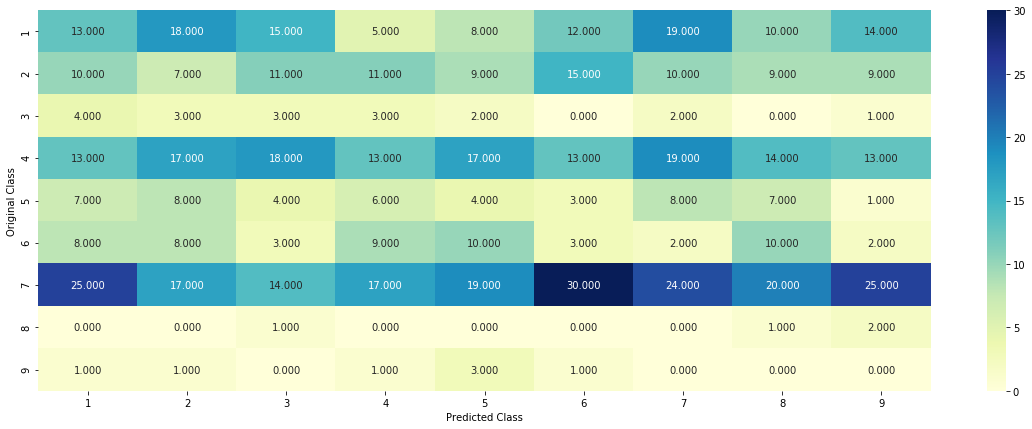

In [39]:
labels=[1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(20,7))
sns.heatmap(C,annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

### Precision matrix

In [40]:
B =(C/C.sum(axis=0))
print(B)

[[0.16049383 0.2278481  0.2173913  0.07692308 0.11111111 0.15584416
  0.22619048 0.14084507 0.20895522]
 [0.12345679 0.08860759 0.15942029 0.16923077 0.125      0.19480519
  0.11904762 0.12676056 0.13432836]
 [0.04938272 0.03797468 0.04347826 0.04615385 0.02777778 0.
  0.02380952 0.         0.01492537]
 [0.16049383 0.21518987 0.26086957 0.2        0.23611111 0.16883117
  0.22619048 0.1971831  0.19402985]
 [0.08641975 0.10126582 0.05797101 0.09230769 0.05555556 0.03896104
  0.0952381  0.09859155 0.01492537]
 [0.09876543 0.10126582 0.04347826 0.13846154 0.13888889 0.03896104
  0.02380952 0.14084507 0.02985075]
 [0.30864198 0.21518987 0.20289855 0.26153846 0.26388889 0.38961039
  0.28571429 0.28169014 0.37313433]
 [0.         0.         0.01449275 0.         0.         0.
  0.         0.01408451 0.02985075]
 [0.01234568 0.01265823 0.         0.01538462 0.04166667 0.01298701
  0.         0.         0.        ]]


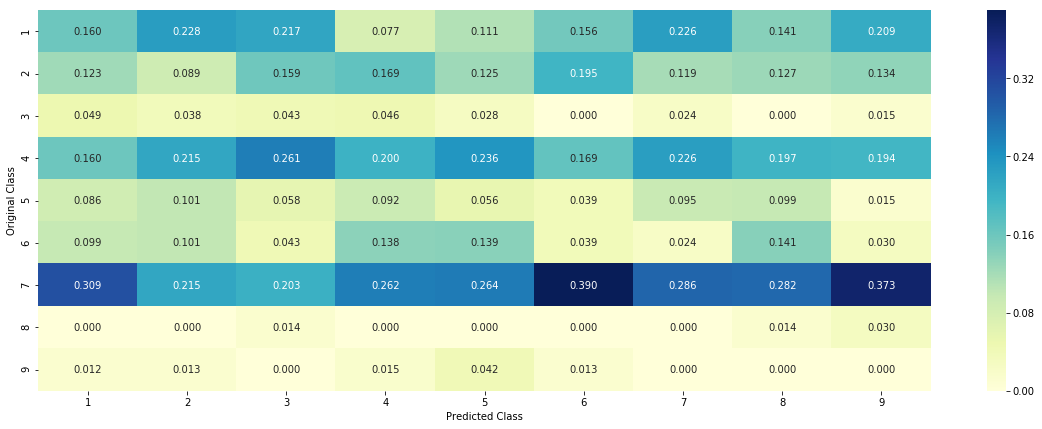

In [41]:
labels=[1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(20,7))
sns.heatmap(B,annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

### Recall matrix

In [42]:
A =(((C.T)/(C.sum(axis=1))).T)
print(A)
#.T is used to take transpose of the matrix

[[0.11403509 0.15789474 0.13157895 0.04385965 0.07017544 0.10526316
  0.16666667 0.0877193  0.12280702]
 [0.10989011 0.07692308 0.12087912 0.12087912 0.0989011  0.16483516
  0.10989011 0.0989011  0.0989011 ]
 [0.22222222 0.16666667 0.16666667 0.16666667 0.11111111 0.
  0.11111111 0.         0.05555556]
 [0.09489051 0.12408759 0.13138686 0.09489051 0.12408759 0.09489051
  0.13868613 0.10218978 0.09489051]
 [0.14583333 0.16666667 0.08333333 0.125      0.08333333 0.0625
  0.16666667 0.14583333 0.02083333]
 [0.14545455 0.14545455 0.05454545 0.16363636 0.18181818 0.05454545
  0.03636364 0.18181818 0.03636364]
 [0.13089005 0.08900524 0.07329843 0.08900524 0.09947644 0.15706806
  0.12565445 0.10471204 0.13089005]
 [0.         0.         0.25       0.         0.         0.
  0.         0.25       0.5       ]
 [0.14285714 0.14285714 0.         0.14285714 0.42857143 0.14285714
  0.         0.         0.        ]]


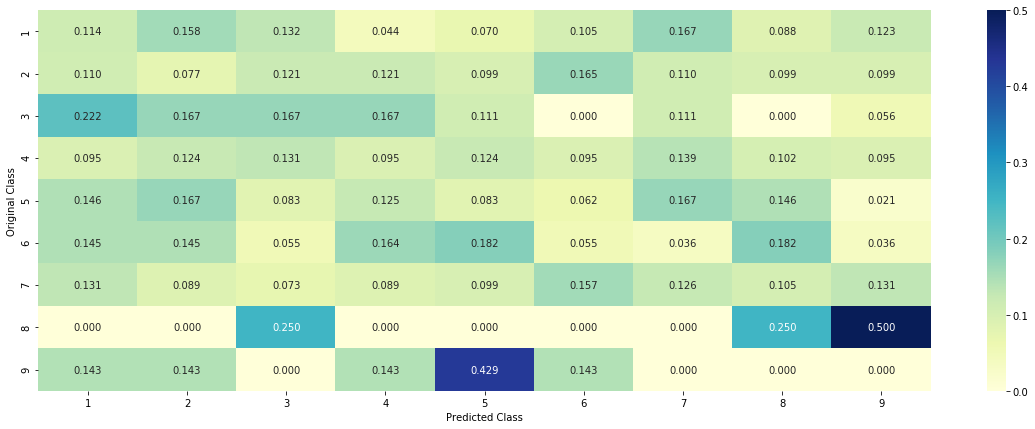

In [43]:
labels=[1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(20,7))
sns.heatmap(A,annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

## Evaluating Gene Column

Now we will look at each independent column to make sure its relavent for my target variable but the question is, how? Let's understand with our first column Gene which is categorial in nature.

So, lets explore column ***Gene*** and lets look at its distribution. 

In [44]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 222
BRCA1     170
TP53      103
EGFR       91
PTEN       80
BRCA2      79
KIT        67
BRAF       62
ALK        46
ERBB2      42
PDGFRA     39
Name: Gene, dtype: int64


Lets see the number of unique values present in gene

In [45]:
unique_genes.shape[0]

222

Lets look at the comulative distribution of unique Genes values

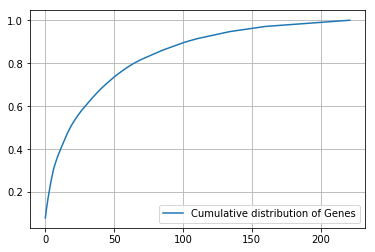

In [46]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

So, now we need to convert these categorical variable to appropirate format which my machine learning algorithm will be able to take as an input.

So we have 2 techniques to deal with it. 

<ol><li>
     ***One-hot encoding*** </li>
    <li> ***Response Encoding*** (Mean imputation) </li>
</ol>

Let's use both of them to see which one work the best. So lets start encoding using one hot encoder

In [47]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

#print(train_gene_feature_onehotCoding)

Let's check the number of column generated after one hot encoding. One hot encoding will always return higher number of column.

In [48]:
#column names after one-hot encoding for Gene column
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1b',
 'arid2',
 'asxl1',
 'asxl2',
 'atm',
 'atrx',
 'aurka',
 'aurkb',
 'axl',
 'b2m',
 'bap1',
 'bard1',
 'bcl10',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk8',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'dusp4',
 'egfr',
 'eif1ax',
 'elf3',
 'ep300',
 'epas1',
 'epcam',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fam58a',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgf3',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt1',
 'flt3',
 'foxa1',
 'foxp1',
 'gata3',
 'gna11',
 'gnaq',
 'gnas',
 'h3f3a',
 'hist1h1c',
 'hla',
 'hnf1a',
 'hras',
 'idh1',
 'idh2',
 'igf1r',
 'ikbke',
 'il7r',
 'inpp4b',
 'jak1',

Now, lets also create Response encoding columns for Gene column

In [49]:
# code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# algorithm
# ----------
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

In [50]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

Let's look at columns after applying response encoding. We must be having 9 columns for Gene column after response encoding.

In [51]:
train_gene_feature_responseCoding.shape

(2124, 9)

Now, question is how good is Gene column feature to predict my 9 classes. One idea could be that we will build model having only gene column with one hot encoder with simple model like Logistic regression. If log loss with only one column Gene comes out to be better than random model, than this feature is important.

In [52]:
# We need a hyperparemeter for SGD classifier.
alpha=[10**x for x in range(-5,1)]

In [53]:
# We will be using SGD classifier
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# We will also be using Calibrated Classifier to get the result into probablity format t be used for log loss

cv_log_error_array=[]
for i in alpha:
    
    clf= SGDClassifier(alpha=i, penalty='l2', loss='log',random_state=42)
    clf.fit(train_gene_feature_onehotCoding,y_train)
    sig_clf= CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding,y_train)
    predict_y= sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv,predict_y,labels=clf.classes_,eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.4361312087453404
For values of alpha =  0.0001 The log loss is: 1.272213952681375
For values of alpha =  0.001 The log loss is: 1.3079337365060835
For values of alpha =  0.01 The log loss is: 1.41852493574251
For values of alpha =  0.1 The log loss is: 1.4817507972614994
For values of alpha =  1 The log loss is: 1.5107219845634732


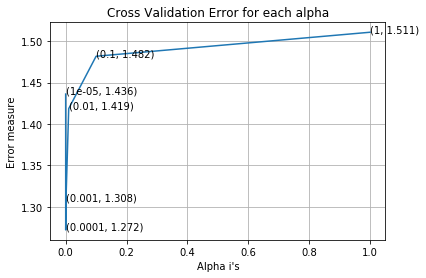

In [54]:
# Lets plot the same to check the best Alpha value
fig,ax=plt.subplots()
ax.plot(alpha,cv_log_error_array)

for i,txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)),(alpha[i],cv_log_error_array[i]))

plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [55]:
# Lets use best alpha value as we can see from above graph and compute log loss
best_alpha = np.argmin(cv_log_error_array)

clf= SGDClassifier(alpha=alpha[best_alpha],penalty='l2',loss='log',random_state=42)
clf.fit(train_gene_feature_onehotCoding,y_train)

sig_clf= CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding,y_train)

predict_y= sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.0001 The train log loss is: 1.0038052027282092
For values of best alpha =  0.0001 The cross validation log loss is: 1.272213952681375
For values of best alpha =  0.0001 The test log loss is: 1.239287643182228


Now lets check how many values are overlapping between train, test or between CV and train

In [56]:
test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage= cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

In [57]:
print('1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

1. In test data 645 out of 665 : 96.99248120300751
2. In cross validation data 502 out of  532 : 94.3609022556391


## Evaluating Variation column

Variation is also a categorical variable so we have to deal in same way like we have done for ***Gene*** column. We will again get the one hot encoder and response enoding variable for variation column.

In [58]:
unique_variations= train_df['Variation'].value_counts()
print('The number of unique variations are ' , unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

The number of unique variations are  1932
Truncating_Mutations    54
Deletion                52
Amplification           42
Fusions                 21
Overexpression           6
G12V                     3
E17K                     3
Y64A                     2
Y42C                     2
Q209L                    2
Name: Variation, dtype: int64


Lets look at the comulative distribution of unique ***variation*** values

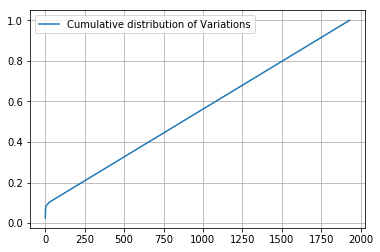

In [59]:
s= sum(unique_variations.values)
h= unique_variations.values/s
c= np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

Lets convert the variation column using one hot encoder column

In [60]:
# one-hot encoding of Gene feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

Lets look at shape of one hot encoder column for variation

In [61]:
train_variation_feature_onehotCoding.shape

(2124, 1963)

Lets do the same for variation column and generate response encoding for the same.

In [62]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

Lets look at the shape of this response encoding resultLets look at the shape of this response encoding result

In [63]:
train_variation_feature_responseCoding.shape

(2124, 9)

Lets again build the model with only column name of ***variation*** column

In [64]:
# We need a hyperparemeter for SGD classifier.
alpha=[10**x for x in range(-5,1)]

In [65]:
# We will be using SGD classifier
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# We will also be using Calibrated Classifier to get the result into probablity format t be used for log loss
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.681313979236167
For values of alpha =  0.0001 The log loss is: 1.6718865965217045
For values of alpha =  0.001 The log loss is: 1.6717208476122545
For values of alpha =  0.01 The log loss is: 1.6744406644647474
For values of alpha =  0.1 The log loss is: 1.6781976645745178
For values of alpha =  1 The log loss is: 1.680754338725409


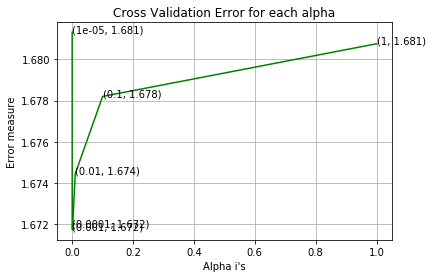

In [66]:
# Lets plot the same to check the best Alpha value
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [67]:
# Lets use best alpha value as we can see from above graph and compute log loss
best_alpha = np.argmin(cv_log_error_array)

clf= SGDClassifier(alpha=alpha[best_alpha],penalty='l2',loss='log',random_state=42)
clf.fit(train_variation_feature_onehotCoding,y_train)

sig_clf= CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding,y_train)

predict_y= sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.001 The train log loss is: 1.1046143679249374
For values of best alpha =  0.001 The cross validation log loss is: 1.6717208476122545
For values of best alpha =  0.001 The test log loss is: 1.7165906191188132


In [68]:
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage= cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]

In [69]:
print('1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

1. In test data 60 out of 665 : 9.022556390977442
2. In cross validation data 66 out of  532 : 12.406015037593985


## Evaluating Text column

In [70]:
# cls_text is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word


def extract_dictionary_paddle(cls_text):
    
    dictionary=defaultdict(int)
    for index,row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word]+=1
    
    return dictionary

In [71]:
import math

def get_text_responsecoding(df):
    
    text_feature_responseCoding=np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index=0
        for index,row in df.iterrows():
            sum_prob=0
            for word in row['TEXT'].split():
                sum_prob+=math.log(((dict_list[i].get(word,0)+10)/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i]=math.exp(sum_prob/len(row['TEXT'].split()))
            row_index+=1
    return text_feature_responseCoding


In [72]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding= text_vectorizer.fit_transform(train_df['TEXT'])

# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts= train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured

text_fea_dict= dict(zip(list(train_text_features),train_text_fea_counts)) 

print("The total number of unique words in the train data :", len(train_text_features))



The total number of unique words in the train data : 52774


In [73]:
dict_list=[]

# dict_list =[] contains 9 dictoinaries each corresponds to a class

for i in range(1,10):
    cls_text=train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data

total_dict= extract_dictionary_paddle(train_df)

confuse_array=[]

for i in train_text_features:
    ratios=[]
    max_val=-1
    
    for j in range(0,9):
        ratios.append((dict_list)[j][i]+10/(total_dict[i]+90))
    confuse_array.append(ratios)

confuse_array=np.array(confuse_array)
print(confuse_array)

[[2.13004305e+02 7.10043048e+01 5.00430478e+00 ... 3.17004305e+02
  4.30477830e-03 1.20043048e+01]
 [7.74001755e+02 6.55001755e+02 6.80017553e+01 ... 1.92700176e+03
  4.30017553e+01 1.17001755e+02]
 [1.02040816e-01 3.10204082e+00 1.02040816e-01 ... 5.10204082e+00
  1.02040816e-01 1.02040816e-01]
 ...
 [1.10309278e+00 2.10309278e+00 1.03092784e-01 ... 1.10309278e+00
  1.03092784e-01 1.03092784e-01]
 [1.07526882e-01 1.10752688e+00 1.07526882e-01 ... 2.10752688e+00
  1.07526882e-01 1.07526882e-01]
 [1.09523810e+00 9.52380952e-02 9.52380952e-02 ... 1.20952381e+01
  9.52380952e-02 2.09523810e+00]]


In [74]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)


In [75]:
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [76]:
# don't forget to normalize every feature

train_text_feature_onehotCoding= normalize(train_text_feature_onehotCoding,axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding= text_vectorizer.transform(test_df['TEXT'])
#normalizing text feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

cv_text_feature_onehotCoding= text_vectorizer.transform(cv_df['TEXT'])

cv_text_feature_onehotCoding=  normalize(cv_text_feature_onehotCoding,axis=0)



In [77]:
sorted_text_fea_dict= dict(sorted(text_fea_dict.items(),key= lambda x:x[1],reverse=True))
sorted_text_occur= np.array(list(sorted_text_fea_dict.values()))
print(sorted_text_occur)

[153410 121275  81578 ...      3      3      3]


In [78]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({3: 4877, 4: 3773, 5: 3040, 6: 2547, 7: 2092, 8: 1824, 10: 1714, 9: 1689, 12: 1249, 11: 1078, 14: 1004, 15: 996, 13: 881, 18: 742, 16: 669, 17: 659, 20: 599, 24: 550, 21: 494, 19: 491, 28: 470, 22: 464, 34: 393, 27: 391, 30: 389, 23: 373, 25: 361, 26: 356, 51: 287, 36: 279, 32: 278, 35: 273, 29: 271, 31: 270, 33: 258, 42: 235, 40: 221, 38: 217, 37: 203, 45: 202, 43: 193, 39: 187, 41: 181, 46: 173, 44: 173, 50: 169, 49: 166, 52: 162, 48: 162, 56: 155, 54: 155, 47: 148, 63: 139, 60: 131, 55: 129, 57: 128, 59: 126, 58: 119, 53: 118, 72: 109, 70: 108, 61: 107, 68: 104, 62: 103, 84: 98, 64: 98, 66: 97, 78: 92, 67: 91, 81: 88, 65: 86, 85: 85, 77: 85, 76: 84, 69: 84, 90: 81, 80: 81, 74: 80, 71: 78, 75: 74, 73: 72, 79: 70, 102: 69, 88: 69, 83: 69, 82: 69, 86: 68, 96: 66, 91: 66, 105: 63, 98: 63, 111: 60, 89: 60, 97: 59, 94: 59, 87: 59, 120: 58, 100: 57, 93: 57, 112: 56, 114: 53, 103: 53, 106: 52, 115: 51, 132: 50, 104: 50, 95: 50, 92: 50, 126: 49, 133: 47, 110: 47, 128: 46, 109: 46, 12

Lets build the model with only ***text*** column

In [79]:
cv_log_error_array=[]

for i in alpha:
    clf= SGDClassifier(alpha=i,penalty='l2',loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding,y_train)
    
    sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(train_text_feature_onehotCoding,y_train)
    
    predict_y=sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv,predict_y,labels=clf.classes_,eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))


For values of alpha =  1e-05 The log loss is: 1.3731565619218964
For values of alpha =  0.0001 The log loss is: 1.3462043902174263
For values of alpha =  0.001 The log loss is: 1.2378793660053546
For values of alpha =  0.01 The log loss is: 1.2744107685296555
For values of alpha =  0.1 The log loss is: 1.4342902045842898
For values of alpha =  1 The log loss is: 1.614706331081414


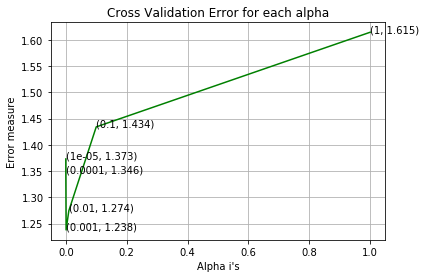

In [80]:
fig,ax=plt.subplots()

ax.plot(alpha,cv_log_error_array,c='g')

for i,txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)),(alpha[i],cv_log_error_array[i]))

plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


In [81]:
best_alpha= np.argmin(cv_log_error_array)

clf= SGDClassifier(alpha=alpha[best_alpha],penalty='l2',loss='log',random_state=42)
clf.fit(train_text_feature_onehotCoding,y_train)

sig_clf= CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_text_feature_onehotCoding,y_train)

predict_y= sig_clf.predict_proba(train_text_feature_onehotCoding)

print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.001 The train log loss is: 0.7260590080098082
For values of best alpha =  0.001 The cross validation log loss is: 1.2378793660053546
For values of best alpha =  0.001 The test log loss is: 1.3129086951908322


Lets check the overlap of text data

In [82]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [83]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

96.727 % of word of test data appeared in train data
97.48 % of word of Cross Validation appeared in train data


So, all 3 columns are going to be important.

## Data prepration for Machine Learning models

Lets create few functions which we will be using later

In [84]:
def report_log_loss(train_x,train_y,test_x,test_y,clf):
    clf.fit(train_x,train_y)
    sig_clf= CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(train_x,train_y)
    sig_clf_probs= sig_clf.predict_proba(test_x)
    return log_loss(test_y,sig_clf_proba, eps=1e-15)
    

In [85]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y,predict_y):
    C=confusion_matrix(test_y,predict_y)
    
    A=  A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0)) 
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    
    print("-"*25,"Confusion Matrix for given data","-"*25)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    
    print("-"*25, "Precision matrix (Columm Sum=1)", "-"*25)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    
    # representing B in heatmap format
    
    print("-"*25 ," Recall matrix (Row sum=1) ","-"*25)
    plt.figure(figsize=(20,7))
    sns.heatmap(A,annot=True,cmap="YlGnBu",fmt=".3f",xticklabels=labels,yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
def predict_and_plot_confusion_matrix(train_x,train_y,test_x,test_y,clf):
        
        clf.fit(train_x,train_y)
        sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
        sig_clf.fit(train_x,train_y)
        pred_y=sig_clf.predict(test_x)
        
        # for calculating log_loss we willl provide the array of probabilities belongs to each class
        print("log Loss is : ",log_loss(test_y,sig_clf.predict_proba(test_x)))
        # calculating the number of data points that are misclassified
        print("Number of mis-classified points are :",np.count_nonzero((pred_y-test_y))/test_y.shape[0])
        plot_confusion_matrix(test_y,pred_y)
        

In [86]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

## Combining all 3 features together

In [87]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]


train_gene_var_onehotCoding= hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding= hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding= hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

#print(" Gene_var stacking for training")
#print(test_gene_var_onehotCoding)

train_x_onehotCoding= hstack((train_gene_var_onehotCoding,train_text_feature_onehotCoding)).tocsr()
train_y= np.array(list(train_df['Class']))

test_x_onehotCoding= hstack((test_gene_var_onehotCoding,test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding= hstack((cv_gene_var_onehotCoding,cv_text_feature_onehotCoding)).tocsr()
cv_y= np.array(list(cv_df['Class']))

train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))


train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


In [88]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 54958)
(number of data points * number of features) in test data =  (665, 54958)
(number of data points * number of features) in cross validation data = (532, 54958)


In [89]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


# Building Machine Learning model

Lets start the first model which is most suitable when we have lot of text column data. So, we will start with Naive Bayes.

In [90]:
# http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

for alpha = 1e-05
Log Loss : 1.3074181085805996
for alpha = 0.0001
Log Loss : 1.3037296919581813
for alpha = 0.001
Log Loss : 1.300514327642346
for alpha = 0.1
Log Loss : 1.3124267460867667
for alpha = 1
Log Loss : 1.3447434639792828
for alpha = 10
Log Loss : 1.4408741389658082
for alpha = 100
Log Loss : 1.4082275024892232
for alpha = 1000
Log Loss : 1.346026622664744


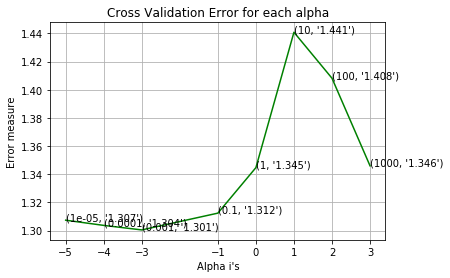

In [91]:
fig,ax= plt.subplots()

ax.plot(np.log10(alpha),cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [92]:
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.001 The train log loss is: 0.8287563466629349
For values of best alpha =  0.001 The cross validation log loss is: 1.300514327642346
For values of best alpha =  0.001 The test log loss is: 1.3332362531595394


Testing our Naive Bayes model with best found value of alpha on testing data

Log Loss is :  1.300514327642346
Number of missclassified point : 0.40601503759398494
------------------------- Confusion Matrix for given data -------------------------


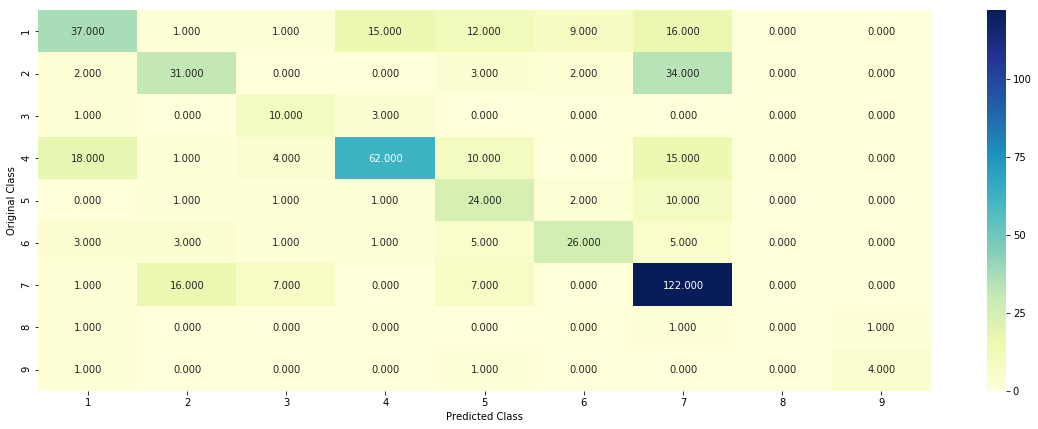

------------------------- Precision matrix (Columm Sum=1) -------------------------


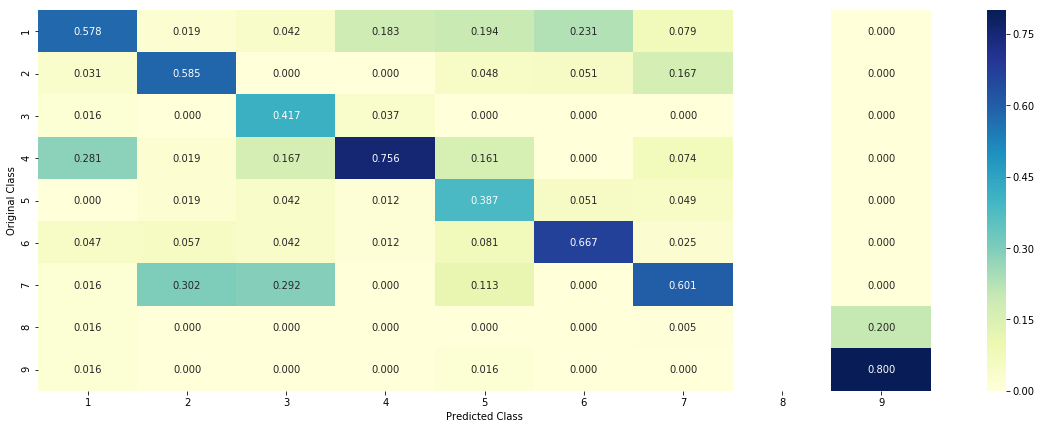

-------------------------  Recall matrix (Row sum=1)  -------------------------


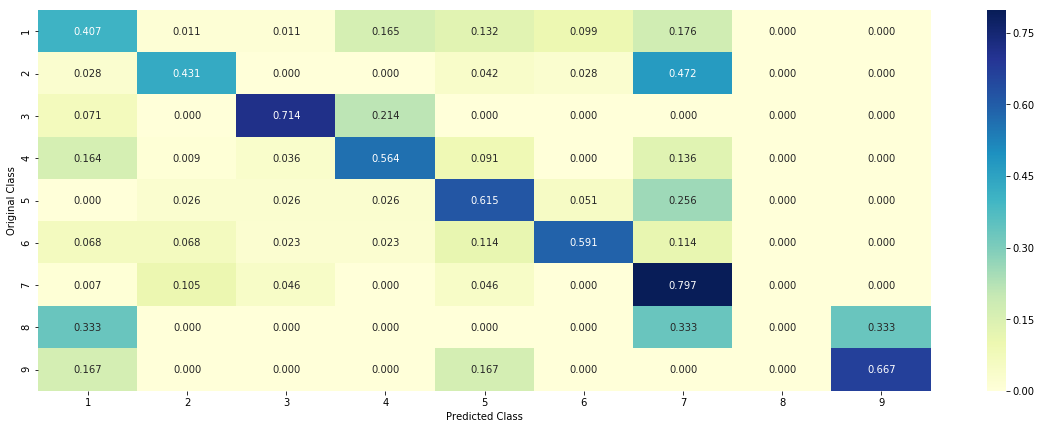

In [93]:
clf=MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding,train_y)
sig_clf= CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_x_onehotCoding,train_y)
sig_clf_probs= sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss is : ",log_loss(cv_y,sig_clf_probs))
print("Number of missclassified point :",np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)-cv_y))/cv_y.shape[0])

plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

### Interpretability of our model

In [94]:
test_point_index=1
no_feature=100
predicted_cls=sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:" , np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
print("-"*100)
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print(indices)
print("-"*100)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 3
Predicted Class Probabilities: [[0.1098 0.0938 0.2782 0.1313 0.198  0.0465 0.1308 0.0064 0.0052]]
Actual Class : 3
----------------------------------------------------------------------------------------------------
[[  135    25     6    85   155   215 12257   170    69   213 41105 52688
  39474 16427 14980 43942 53015 45249 53246 34398 36667 42711 16416 42467
  18957 43262 21871 18792 47976 31933 49040 49273 43014  5906 45321  7891
  42808 30016 44470 42806  7834  6036 52693  4725 45323 12990 30994 49270
  51540  2775 32009 42777 35602 10470 24185 17317 22039 47440 24284  6147
  27613 25389 25844 19893 19929 45199 35100 22037 27612 19905 26176 44592
  34763 11748 29689 19930 52692 51214  4920 51203 19420 34302 11768 13054
   3265 30162 42292  7833 35967 42779 30982 44250 36962  4394  7775 52081
  21476 53435 48083 43294]]
----------------------------------------------------------------------------------------------------
Out of the top  100  features  0 are presen

Lets look at one more point

In [95]:
test_point_index = 10
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0792 0.0679 0.0109 0.6738 0.0314 0.0338 0.0944 0.0047 0.0038]]
Actual Class : 4
--------------------------------------------------
13 Text feature [function] present in test data point [True]
14 Text feature [proteins] present in test data point [True]
15 Text feature [protein] present in test data point [True]
16 Text feature [mammalian] present in test data point [True]
17 Text feature [activity] present in test data point [True]
19 Text feature [experiments] present in test data point [True]
20 Text feature [suppressor] present in test data point [True]
21 Text feature [missense] present in test data point [True]
23 Text feature [functional] present in test data point [True]
24 Text feature [phosphatase] present in test data point [True]
27 Text feature [results] present in test data point [True]
28 Text feature [whereas] present in test data point [True]
29 Text feature [determined] present in test data point [True]
30 Text fea

So Naive Bayes not performing very badly but lets look at other models

# K Nearest Neighbour Classification

In [96]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

for alpha = 5
Log Loss : 1.109512061479416
for alpha = 11
Log Loss : 1.0675746959577423
for alpha = 15
Log Loss : 1.077045571113042
for alpha = 21
Log Loss : 1.0994693703008418
for alpha = 31
Log Loss : 1.1165628422481022
for alpha = 41
Log Loss : 1.1198411209223313
for alpha = 51
Log Loss : 1.1336615602549593
for alpha = 99
Log Loss : 1.1573686401271952


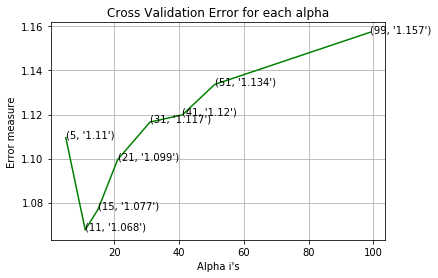

In [97]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [98]:
best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  11 The train log loss is: 0.6216391276702316
For values of best alpha =  11 The cross validation log loss is: 1.0675746959577423
For values of best alpha =  11 The test log loss is: 1.135225847773898


Let's test it on testing dataset with our best alpha value

log Loss is :  1.0675746959577423
Number of mis-classified points are : 0.37406015037593987
------------------------- Confusion Matrix for given data -------------------------


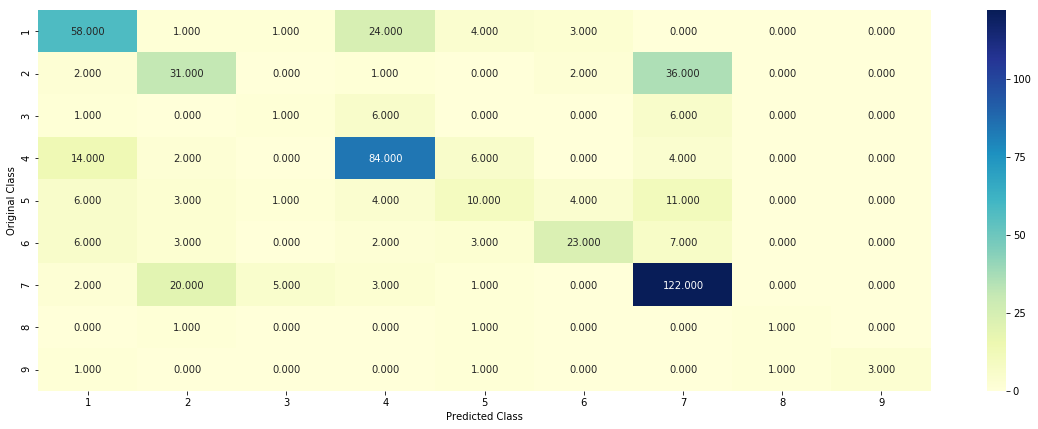

------------------------- Precision matrix (Columm Sum=1) -------------------------


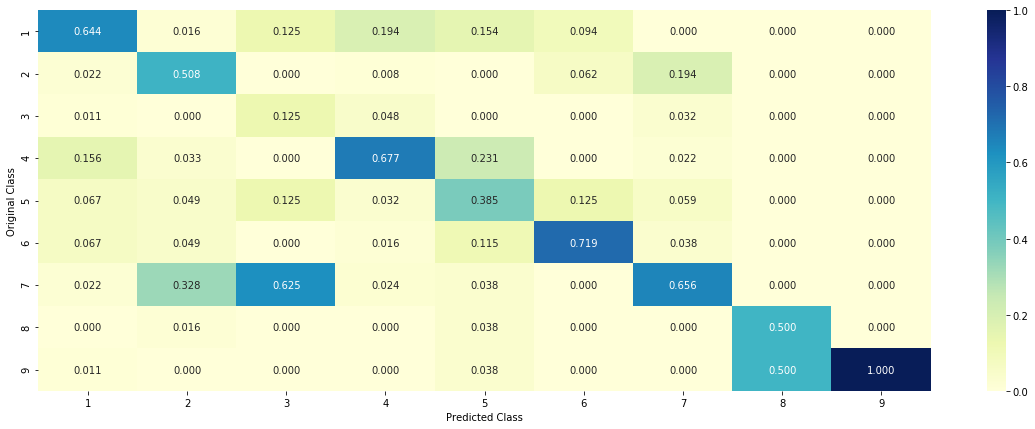

-------------------------  Recall matrix (Row sum=1)  -------------------------


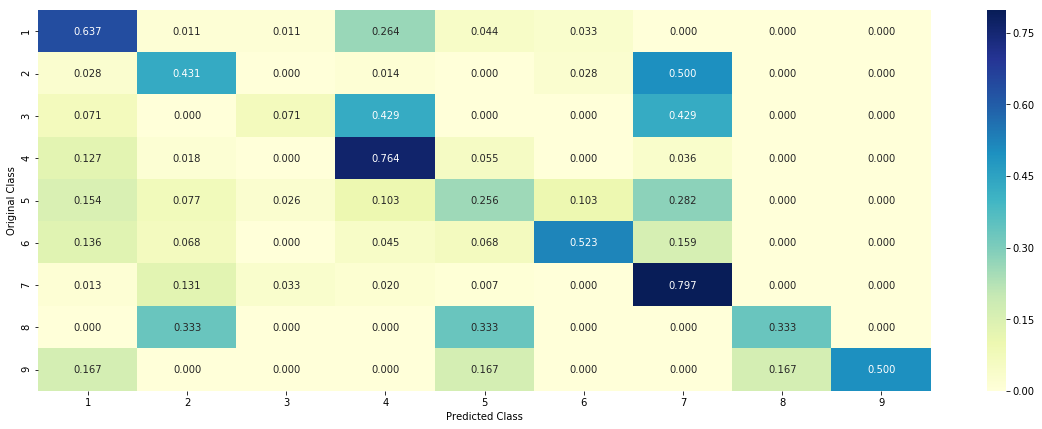

In [99]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

In [100]:
 #Lets look at few test points
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 4
Actual Class : 3
The  11  nearest neighbours of the test points belongs to classes [3 7 7 7 7 5 7 7 7 7 7]
Fequency of nearest points : Counter({7: 9, 3: 1, 5: 1})


# Logistic Regression

### Balancing all classes

In [101]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


for alpha = 1e-06
Log Loss : 1.3908555170381816
for alpha = 1e-05
Log Loss : 1.3880648543535166
for alpha = 0.0001
Log Loss : 1.3213550637719855
for alpha = 0.001
Log Loss : 1.1268128678624387
for alpha = 0.01
Log Loss : 1.1750985465765567
for alpha = 0.1
Log Loss : 1.4522812550014943
for alpha = 1
Log Loss : 1.668389044256635
for alpha = 10
Log Loss : 1.6957334014566423
for alpha = 100
Log Loss : 1.6985462434269465


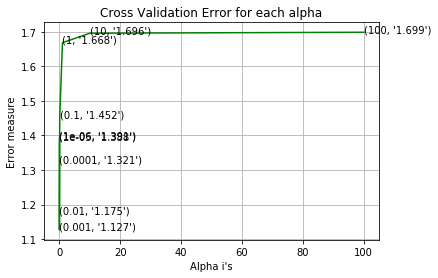

In [102]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [103]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.5895059200471594
For values of best alpha =  0.001 The cross validation log loss is: 1.1268128678624387
For values of best alpha =  0.001 The test log loss is: 1.2263073838500913


Lets test it on testing data using best alpha value

log Loss is :  1.1268128678624387
Number of mis-classified points are : 0.3458646616541353
------------------------- Confusion Matrix for given data -------------------------


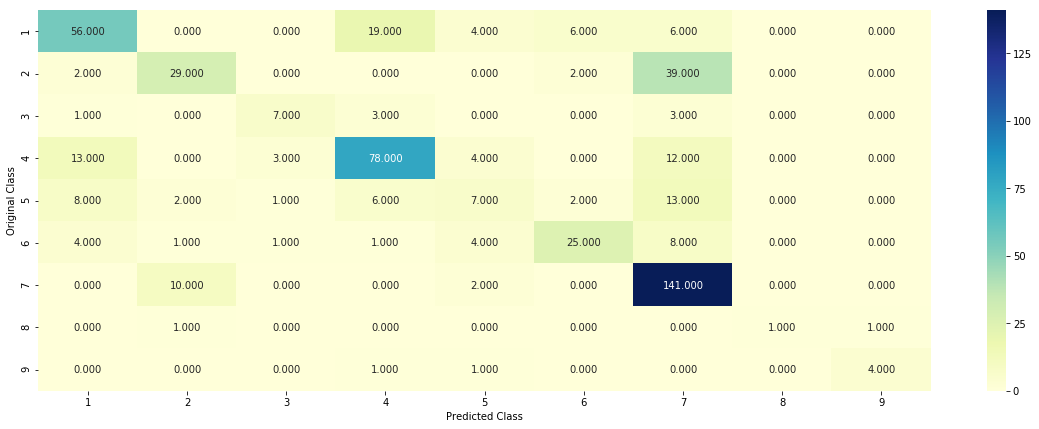

------------------------- Precision matrix (Columm Sum=1) -------------------------


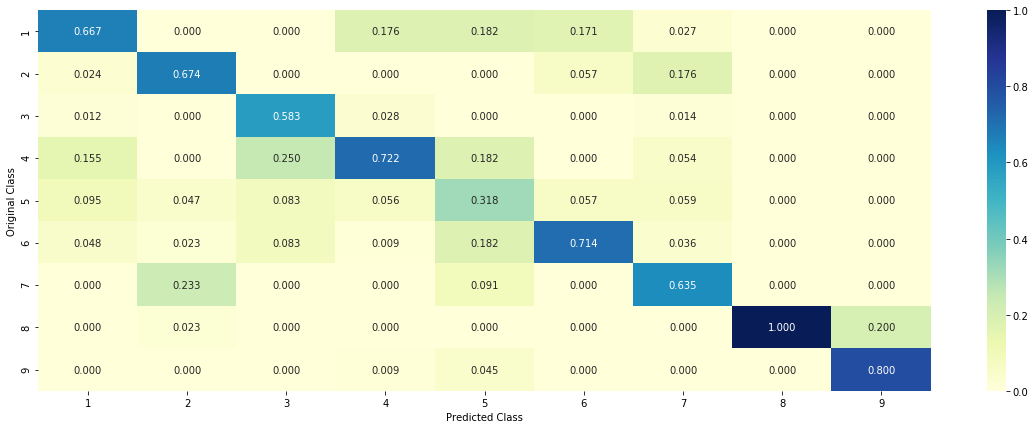

-------------------------  Recall matrix (Row sum=1)  -------------------------


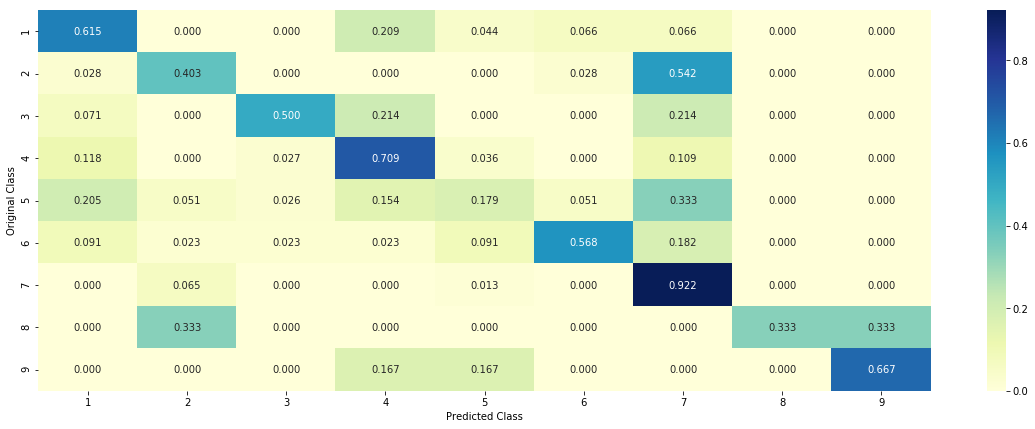

In [104]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

### Feature importance

In [105]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

testing query point and doing interpretability

In [106]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 50
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0748 0.0283 0.0326 0.5795 0.2247 0.0338 0.0175 0.0042 0.0046]]
Actual Class : 5
--------------------------------------------------
195 Text feature [adapted] present in test data point [True]
238 Text feature [instability] present in test data point [True]
319 Text feature [mss] present in test data point [True]
322 Text feature [cmmrd] present in test data point [True]
447 Text feature [deficiencies] present in test data point [True]
Out of the top  500  features  5 are present in query point


In [107]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.014  0.0168 0.0052 0.0098 0.0114 0.0056 0.9293 0.0037 0.0042]]
Actual Class : 7
--------------------------------------------------
15 Text feature [transforming] present in test data point [True]
27 Text feature [constitutively] present in test data point [True]
51 Text feature [stat5] present in test data point [True]
62 Text feature [infect] present in test data point [True]
68 Text feature [py20] present in test data point [True]
72 Text feature [3t3] present in test data point [True]
139 Text feature [stat5a] present in test data point [True]
148 Text feature [frederick] present in test data point [True]
166 Text feature [activated] present in test data point [True]
170 Text feature [autophosphorylation] present in test data point [True]
222 Text feature [oncogene] present in test data point [True]
337 Text feature [eagles] present in test data point [True]
349 Text feature [activation] present in test data point [True]
366 Tex

## Without class balancing

In [108]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


for alpha = 1e-06
Log Loss : 1.3542097101824282
for alpha = 1e-05
Log Loss : 1.3655096116496197
for alpha = 0.0001
Log Loss : 1.3176895293082267
for alpha = 0.001
Log Loss : 1.1664691741873403
for alpha = 0.01
Log Loss : 1.1952559324810368
for alpha = 0.1
Log Loss : 1.3594467427771875
for alpha = 1
Log Loss : 1.561953945866443


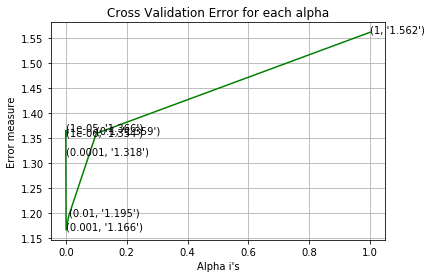

In [109]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [110]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.5904631696968015
For values of best alpha =  0.001 The cross validation log loss is: 1.1664691741873403
For values of best alpha =  0.001 The test log loss is: 1.2707054098417552


Lets test our model with best hyper param

log Loss is :  1.1664691741873403
Number of mis-classified points are : 0.36466165413533835
------------------------- Confusion Matrix for given data -------------------------


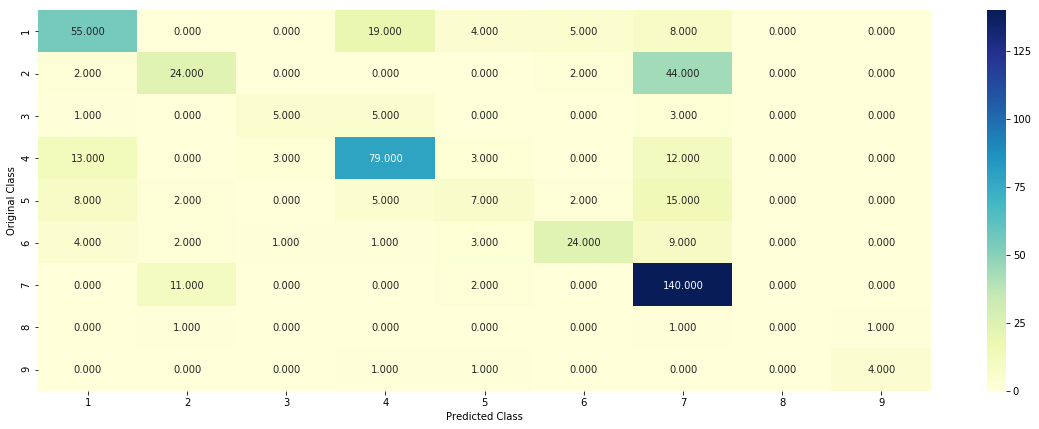

------------------------- Precision matrix (Columm Sum=1) -------------------------


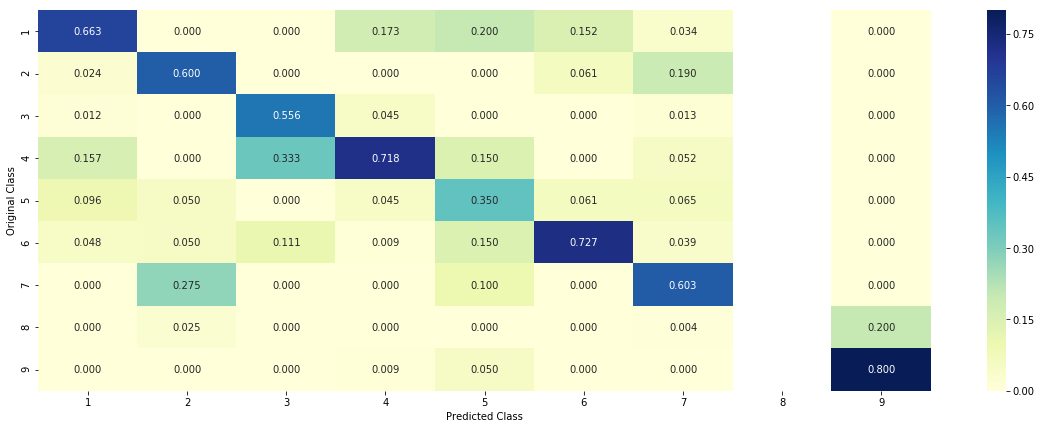

-------------------------  Recall matrix (Row sum=1)  -------------------------


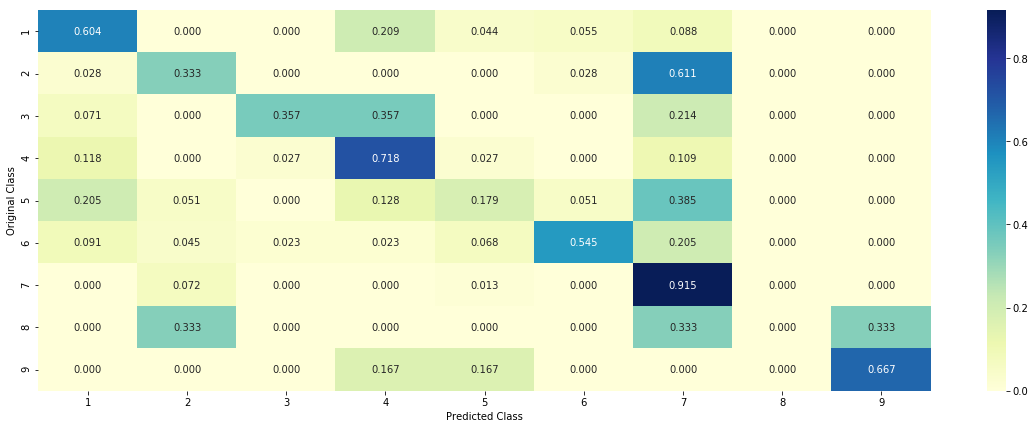

In [111]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

### Testing query point and interpretability

In [112]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.024  0.0305 0.034  0.02   0.0418 0.0063 0.8381 0.0037 0.0016]]
Actual Class : 3
--------------------------------------------------
38 Text feature [transforming] present in test data point [True]
106 Text feature [constitutively] present in test data point [True]
113 Text feature [constitutive] present in test data point [True]
131 Text feature [stat5] present in test data point [True]
176 Text feature [stemcell] present in test data point [True]
229 Text feature [grew] present in test data point [True]
258 Text feature [autophosphorylation] present in test data point [True]
259 Text feature [murine] present in test data point [True]
260 Text feature [autophosphorylated] present in test data point [True]
306 Text feature [activated] present in test data point [True]
404 Text feature [sulfophenyl] present in test data point [True]
405 Text feature [japan] present in test data point [True]
444 Text feature [downstream] present in tes

# Linear Support Vector Machines

In [113]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


for C = 1e-05
Log Loss : 1.3830218141042137
for C = 0.0001
Log Loss : 1.3650656687437583
for C = 0.001
Log Loss : 1.30660560402568
for C = 0.01
Log Loss : 1.188147055416176
for C = 0.1
Log Loss : 1.4069178935365734
for C = 1
Log Loss : 1.6853751220542565
for C = 10
Log Loss : 1.6990289361548259
for C = 100
Log Loss : 1.6990289189872618


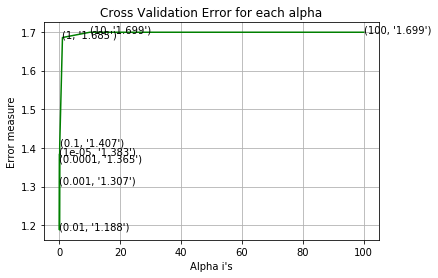

In [114]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [115]:
best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.01 The train log loss is: 0.7032235812281546
For values of best alpha =  0.01 The cross validation log loss is: 1.188147055416176
For values of best alpha =  0.01 The test log loss is: 1.2731561290399647


### Testing model with best alpha values

log Loss is :  1.188147055416176
Number of mis-classified points are : 0.37593984962406013
------------------------- Confusion Matrix for given data -------------------------


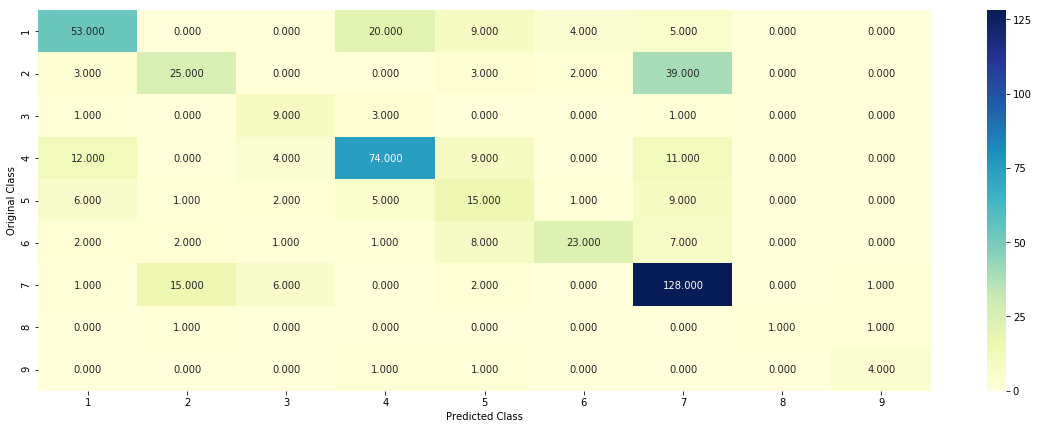

------------------------- Precision matrix (Columm Sum=1) -------------------------


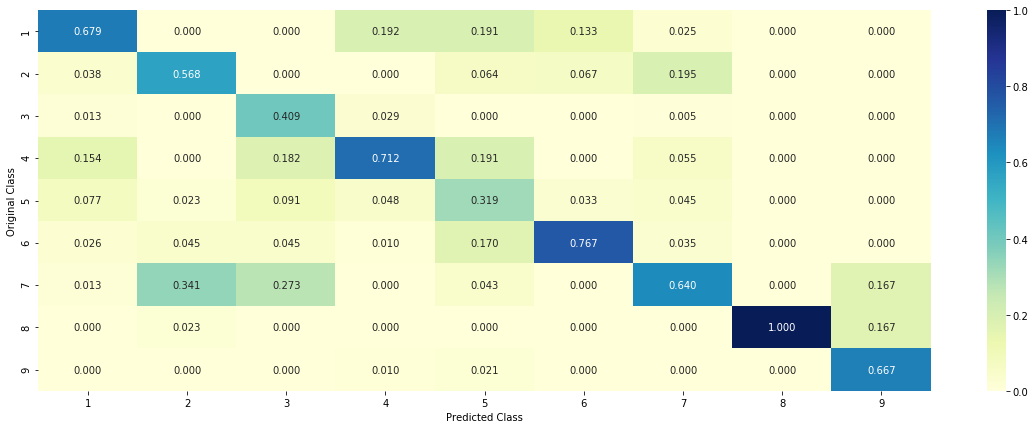

-------------------------  Recall matrix (Row sum=1)  -------------------------


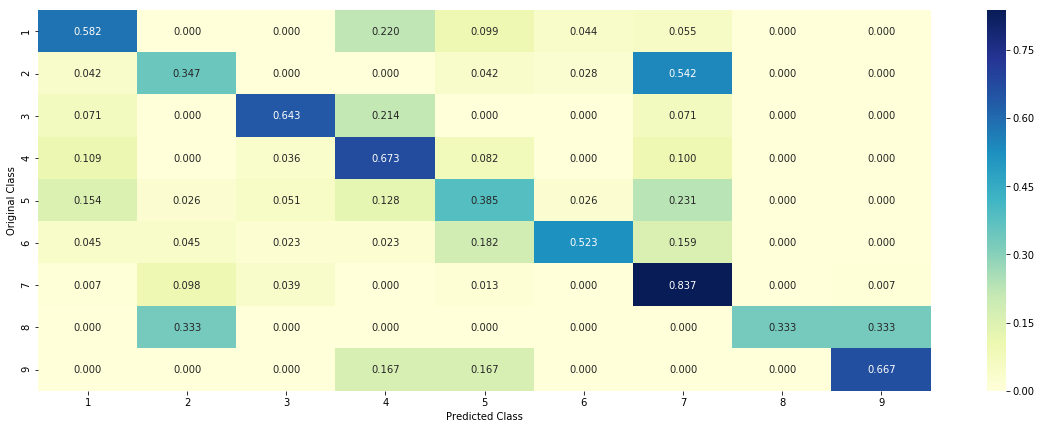

In [116]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

Querying some correctly classified point

In [117]:
clf=SGDClassifier(alpha=alpha[best_alpha],penalty='l2',loss='hinge',random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index=1
no_feature=500
predict_cls=sig_clf.predict(train_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:",np.round(sig_clf.predict_proba(train_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices=np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*75)
get_impfeature_names(indices[0],test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index],no_feature)



Predicted Class : 7
Predicted Class Probabilities: [[0.1067 0.0909 0.0151 0.5613 0.0627 0.0428 0.1082 0.0066 0.0057]]
Actual Class : 3
---------------------------------------------------------------------------
19 Text feature [transforming] present in test data point [True]
59 Text feature [stat5] present in test data point [True]
68 Text feature [constitutively] present in test data point [True]
70 Text feature [grew] present in test data point [True]
74 Text feature [constitutive] present in test data point [True]
80 Text feature [autophosphorylated] present in test data point [True]
114 Text feature [stemcell] present in test data point [True]
122 Text feature [murine] present in test data point [True]
136 Text feature [sulfophenyl] present in test data point [True]
169 Text feature [autophosphorylation] present in test data point [True]
177 Text feature [wehi] present in test data point [True]
178 Text feature [sm] present in test data point [True]
231 Text feature [expressing] pr

# Random Forest Classifier

## Model with One hot encoder

In [118]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []

for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf=RandomForestClassifier(n_estimators=i,criterion='gini',max_depth=j,random_state=42,n_jobs=-1)
        clf.fit(train_x_onehotCoding,train_y)
        sig_clf=CalibratedClassifierCV(clf,method="sigmoid")
        sig_clf.fit(train_x_onehotCoding,train_y)
        sig_clf_probs=sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y,sig_clf_probs,labels=clf.classes_,eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs))
        
        

for n_estimators = 100 and max depth =  5
Log Loss : 1.2926866530602665
for n_estimators = 100 and max depth =  10
Log Loss : 1.206887833576723
for n_estimators = 200 and max depth =  5
Log Loss : 1.2731721823449622
for n_estimators = 200 and max depth =  10
Log Loss : 1.2025179437404805
for n_estimators = 500 and max depth =  5
Log Loss : 1.2685658000252673
for n_estimators = 500 and max depth =  10
Log Loss : 1.1979860389481898
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2719188021392802
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1987618808744092
for n_estimators = 2000 and max depth =  5
Log Loss : 1.272163760951765
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1959548952833652


In [119]:
best_alpha = np.argmin(cv_log_error_array)
clf=RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)],criterion='gini',max_depth=max_depth[int(best_alpha%2)],random_state=42,n_jobs=-1)
clf.fit(train_x_onehotCoding,train_y)
sig_clf=CalibratedClassifierCV(clf,method="sigmoid")
sig_clf.fit(train_x_onehotCoding,train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best estimator =  2000 The train log loss is: 0.6943788338505166
For values of best estimator =  2000 The cross validation log loss is: 1.1959548952833652
For values of best estimator =  2000 The test log loss is: 1.2101904691353245


Lets test it on testing data using best hyper param

log Loss is :  1.1959548952833652
Number of mis-classified points are : 0.37218045112781956
------------------------- Confusion Matrix for given data -------------------------


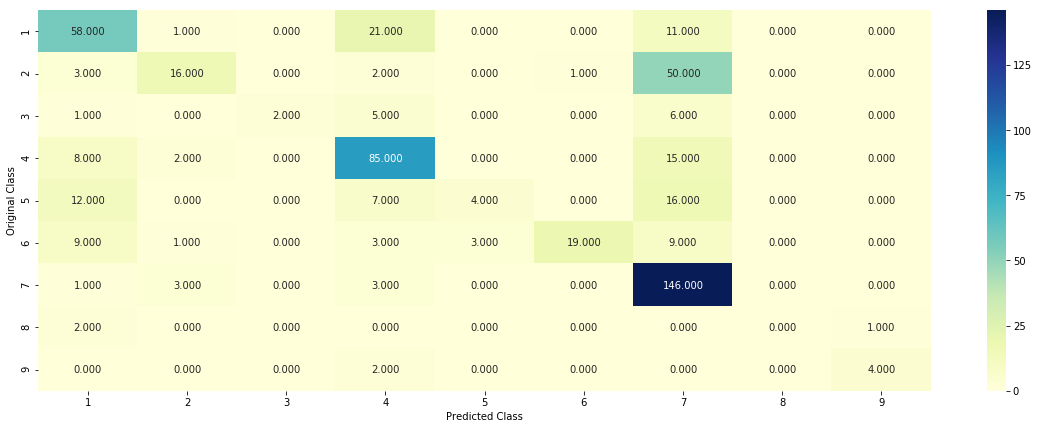

------------------------- Precision matrix (Columm Sum=1) -------------------------


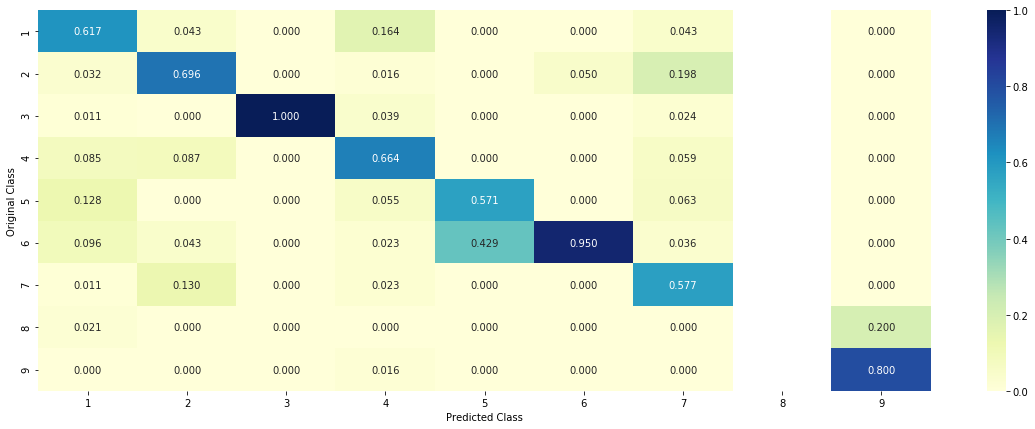

-------------------------  Recall matrix (Row sum=1)  -------------------------


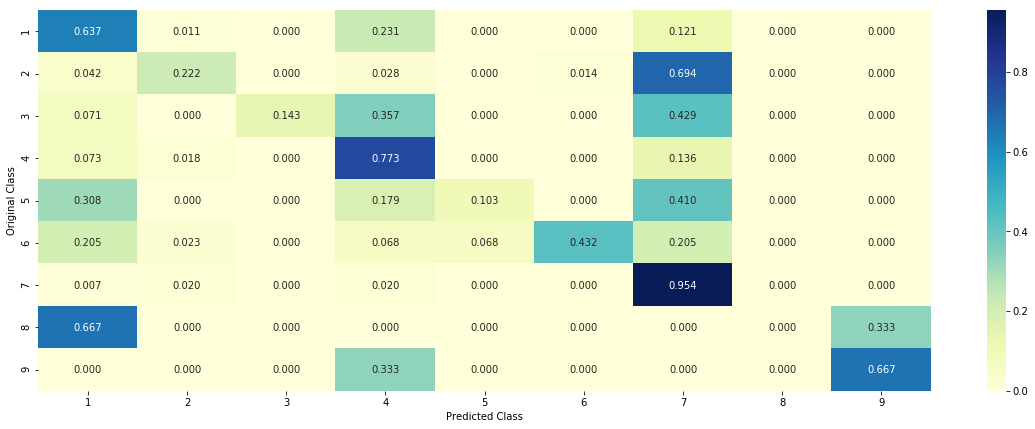

In [120]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [121]:
# test_point_index = 10
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0441 0.0841 0.0266 0.0352 0.0427 0.0299 0.7265 0.0054 0.0054]]
Actual Class : 3
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
1 Text feature [activating] present in test data point [True]
2 Text feature [tyrosine] present in test data point [True]
3 Text feature [activation] present in test data point [True]
4 Text feature [inhibitors] present in test data point [True]
5 Text feature [activated] present in test data point [True]
6 Text feature [constitutive] present in test data point [True]
7 Text feature [treatment] present in test data point [True]
9 Text feature [phosphorylation] present in test data point [True]
10 Text feature [inhibitor] present in test data point [True]
12 Text feature [oncogenic] present in test data point [True]
16 Text feature [signaling] present in test data point [True]
18 Text feature [constitutively] present in test data point [True]
22 T

## RF with Response Coding

In [122]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


for n_estimators = 10 and max depth =  2
Log Loss : 2.1544076893130364
for n_estimators = 10 and max depth =  3
Log Loss : 1.7503611447499026
for n_estimators = 10 and max depth =  5
Log Loss : 1.3631932703968614
for n_estimators = 10 and max depth =  10
Log Loss : 1.8103624697816862
for n_estimators = 50 and max depth =  2
Log Loss : 1.6297797379006216
for n_estimators = 50 and max depth =  3
Log Loss : 1.468884382398534
for n_estimators = 50 and max depth =  5
Log Loss : 1.3618586988472388
for n_estimators = 50 and max depth =  10
Log Loss : 1.6071926276609678
for n_estimators = 100 and max depth =  2
Log Loss : 1.5586744985407457
for n_estimators = 100 and max depth =  3
Log Loss : 1.5145982670672185
for n_estimators = 100 and max depth =  5
Log Loss : 1.355700623276545
for n_estimators = 100 and max depth =  10
Log Loss : 1.6113312097224974
for n_estimators = 200 and max depth =  2
Log Loss : 1.6365109369297044
for n_estimators = 200 and max depth =  3
Log Loss : 1.5396607121765717

In [123]:
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  100 The train log loss is: 0.05785317718197199
For values of best alpha =  100 The cross validation log loss is: 1.355700623276545
For values of best alpha =  100 The test log loss is: 1.4134865061380315


Testing model with best hyper param

log Loss is :  1.3557006232765452
Number of mis-classified points are : 0.4868421052631579
------------------------- Confusion Matrix for given data -------------------------


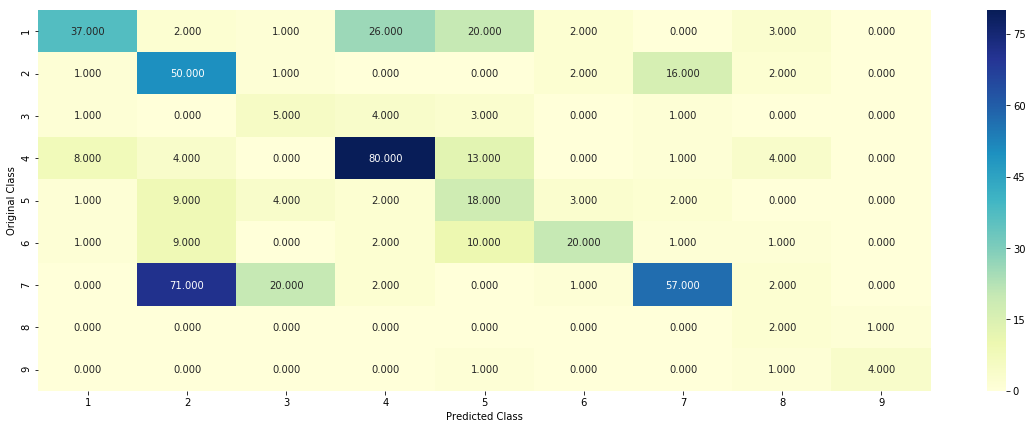

------------------------- Precision matrix (Columm Sum=1) -------------------------


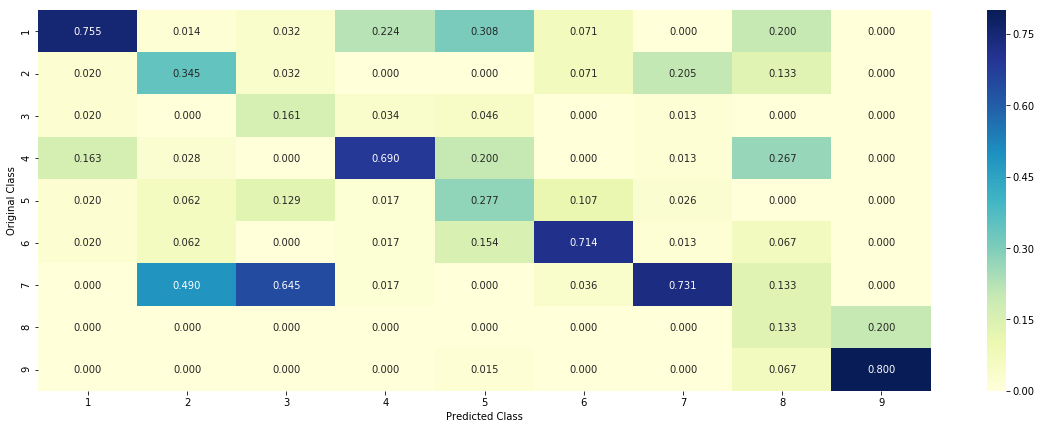

-------------------------  Recall matrix (Row sum=1)  -------------------------


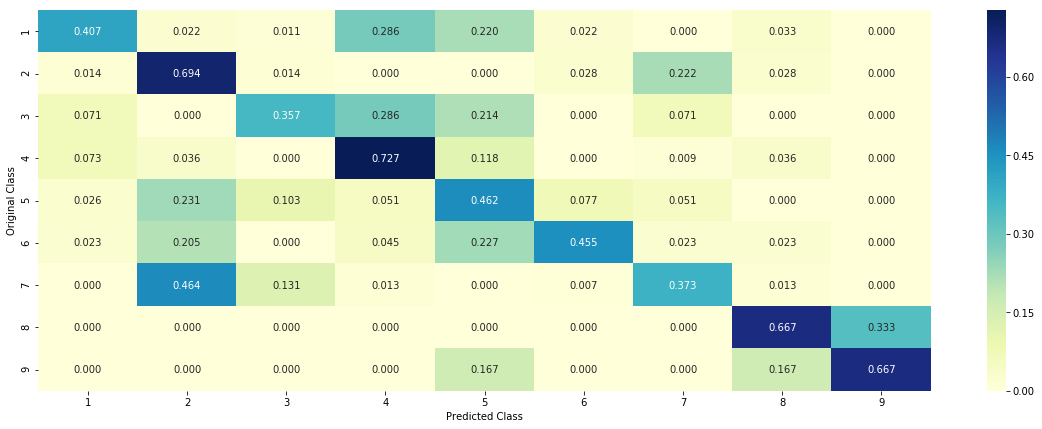

In [124]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

Query the classified point

In [125]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 10
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 4
Predicted Class Probabilities: [[0.0658 0.0325 0.151  0.6316 0.0294 0.0334 0.0066 0.0282 0.0216]]
Actual Class : 4
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Text is important feature
Variation is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature


# Stacking model

In [126]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.12
Support vector machines : Log Loss: 1.68
Naive Bayes : Log Loss: 1.30
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.178
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.040
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.536
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.153
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.253
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.540


Testing with best hyper param

Log loss (train) on the stacking classifier : 0.6367911998406471
Log loss (CV) on the stacking classifier : 1.153471650748786
Log loss (test) on the stacking classifier : 1.244003359511691
Number of missclassified point : 0.40601503759398494
------------------------- Confusion Matrix for given data -------------------------


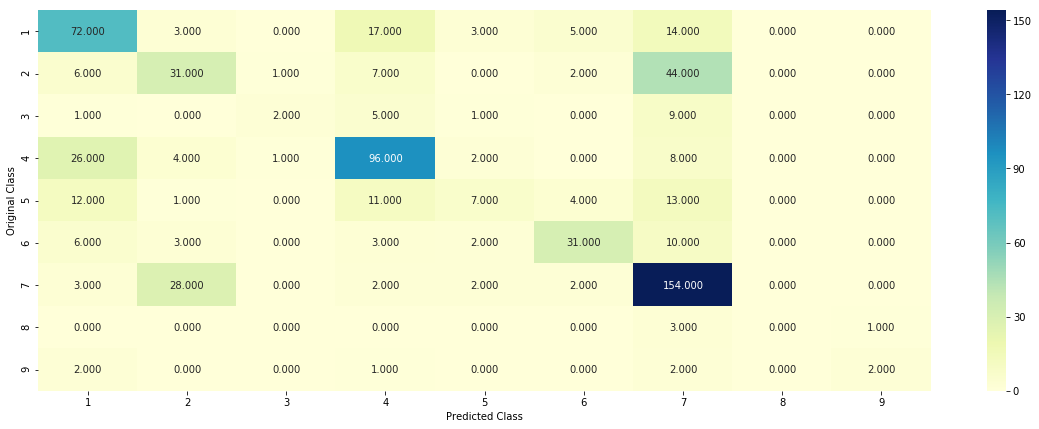

------------------------- Precision matrix (Columm Sum=1) -------------------------


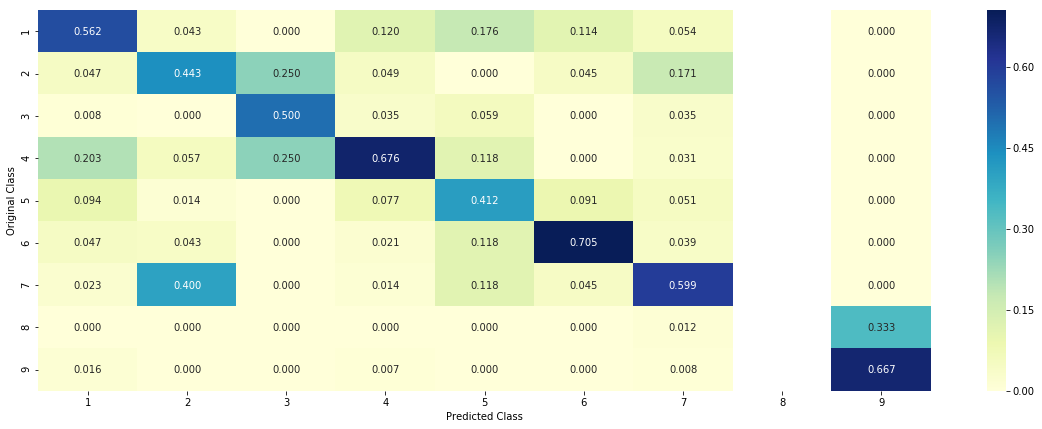

-------------------------  Recall matrix (Row sum=1)  -------------------------


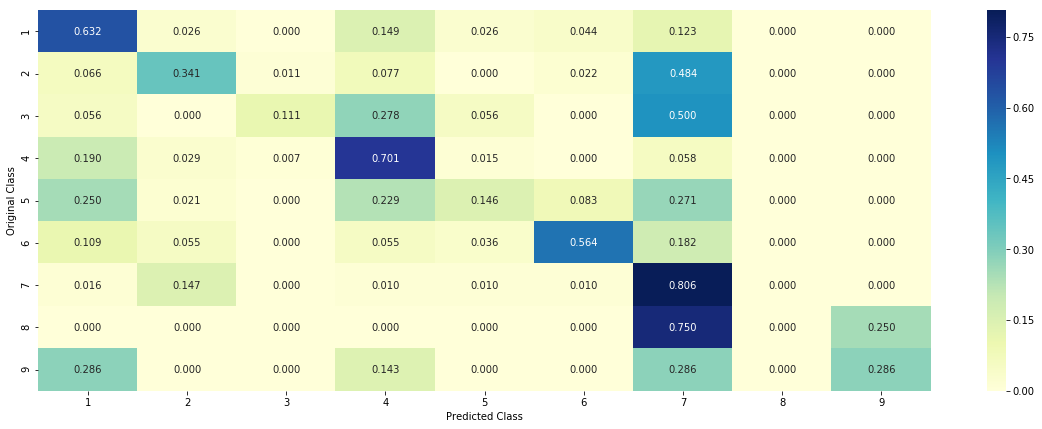

In [127]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)


print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

# Maximum voting Classifier
**Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html**